In [47]:
# Data Manipulation
import pandas as pd

# Spacy Packages
import spacy
nlp = spacy.load('en_core_web_md')
lemmatizer = nlp.get_pipe("lemmatizer")
stopwords = nlp.Defaults.stop_words

# Vizualization
import matplotlib.pyplot as plt
import seaborn as sns

In [48]:
df = pd.read_csv('./data/porsche_review_kaggle.csv')
print(df.shape)
print(df.columns)
df.head()


(233, 4)
Index(['Vehicle_Title', 'Review_Title', 'Review', 'Rating'], dtype='object')


,Vehicle_Title,Review_Title,Review,Rating
0,2015 Porsche Macan SUV Turbo 4dr SUV AWD (3.6L...,Porsche Macan is a Beast,I owned a Porsche Cayenne for two years and e...,5
1,2015 Porsche Macan SUV S 4dr SUV AWD (3.0L 6cy...,Outstanding ride!,"Love my 2015 Porsche Macan S SUV, but please ...",5
2,2015 Porsche Macan SUV S 4dr SUV AWD (3.0L 6cy...,Pretty and comfy,Great looking vehicle with the most comfortab...,4
3,2015 Porsche Macan SUV S 4dr SUV AWD (3.0L 6cy...,"Once you've gone Porsche, it's hard to go back",Crossover that drives like a Porsche- I outgr...,5
4,2015 Porsche Macan SUV Turbo 4dr SUV AWD (3.6L...,The 911 SUV,Fun to drive SUV:very close to handling like ...,5


<AxesSubplot:>

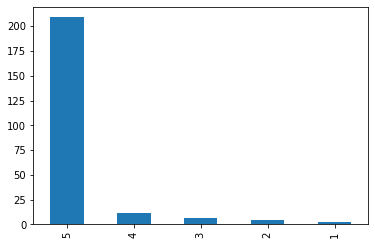

In [49]:
df['Rating'].value_counts().plot(kind='bar')

In [50]:
# Spacy NER (Name Entity Recognition)
one_sentence = df['Review'].iloc[0]
doc = nlp(one_sentence)
spacy.displacy.render(doc, style='ent',jupyter=True)

In [51]:
# Noun Chunks
example_text = df['Review'].iloc[0]
doc = nlp(example_text)
spacy.displacy.render(doc, style='ent', jupyter=True)

for idx, sentence in enumerate(doc.sents):
    for noun in sentence.noun_chunks:
        print(f"sentence {idx+1} has noun chunk '{noun}'")

sentence 1 has noun chunk 'I'
sentence 1 has noun chunk 'a Porsche Cayenne'
sentence 1 has noun chunk 'two years'
sentence 1 has noun chunk 'it'
sentence 1 has noun chunk 'something'
sentence 1 has noun chunk 'a better balance'
sentence 1 has noun chunk 'power'
sentence 1 has noun chunk 'quickness'
sentence 1 has noun chunk 'supreme handling'
sentence 1 has noun chunk 'the road'
sentence 1 has noun chunk 'an SUV'
sentence 2 has noun chunk 'The Macan'
sentence 2 has noun chunk 'the best driving experience'
sentence 2 has noun chunk 'any car'
sentence 2 has noun chunk 'I'
sentence 3 has noun chunk ' The 3.6 L turbo'
sentence 3 has noun chunk 'the standard adaptive suspension'
sentence 3 has noun chunk 'the ride'
sentence 3 has noun chunk 'no other SUV'
sentence 3 has noun chunk 'many 2-door sports cars'
sentence 4 has noun chunk '~4.2'
sentence 4 has noun chunk 'seconds'
sentence 4 has noun chunk 'the ability'
sentence 4 has noun chunk 'curves'
sentence 4 has noun chunk 'higher speeds'
s

In [52]:
# What are People talking about
text = df['Review'].str.cat(sep=' ')
# spaCy enforces a max limit of 1000000 characters for NER and similar use cases.
# Since `text` might be longer than that, we will slice it off here
max_length = 1000000-1
text = text[:max_length]

# removing URLs and '&amp' substrings using regex
import re
url_reg  = r'[a-z]*[:.]+\S+'
text   = re.sub(url_reg, '', text)
noise_reg = r'\&amp'
text   = re.sub(noise_reg, '', text)

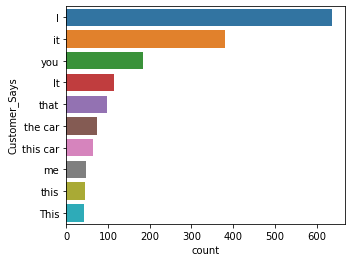

In [53]:
doc = nlp(text)
items_of_interest = list(doc.noun_chunks)
items_of_interest = [str(x) for x in items_of_interest]
#
df_nouns = pd.DataFrame(items_of_interest, columns=["Customer_Says"])
plt.figure(figsize=(5,4))
sns.countplot(y="Customer_Says",
             data=df_nouns,
             order=df_nouns["Customer_Says"].value_counts().iloc[:10].index)
plt.show()

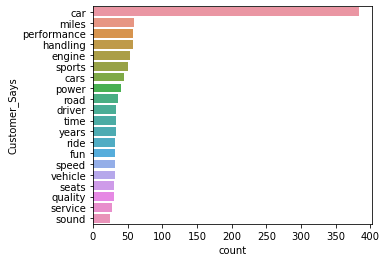

In [54]:
valid_topics = []
for token in doc:
    if (not token.is_stop) and (token.pos_ == "NOUN") and (len(str(token))>2):
        valid_topics.append(token)
        
topics = [str(x) for x in valid_topics]
#
df_nouns = pd.DataFrame(topics, columns=["Customer_Says"])
df_nouns
plt.figure(figsize=(5,4))
sns.countplot(y="Customer_Says",
             data=df_nouns,
             order=df_nouns["Customer_Says"].value_counts().iloc[:20].index)
plt.show()

In [55]:
# Exploring Entities
entity_topics = []
for ent in doc.ents:
    if ent.label_ not in ["PERCENT", "CARDINAL", "DATE"]:
#         print(ent.text,ent.label_)
        entity_topics.append(ent.text.strip())

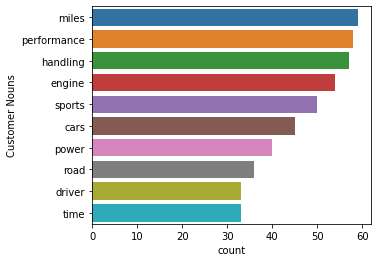

In [56]:
df_ttopics = pd.DataFrame(topics, columns=["Customer Nouns"])
plt.figure(figsize=(5,4))
sns.countplot(y="Customer Nouns",
             data=df_ttopics,
             order=df_ttopics["Customer Nouns"].value_counts().iloc[1:11].index)
plt.show()

In [57]:
df_ttopics

,Customer Nouns
0,years
1,balance
2,power
3,quickness
4,handling
...,...
4390,handling
4391,porshe
4392,price
4393,car


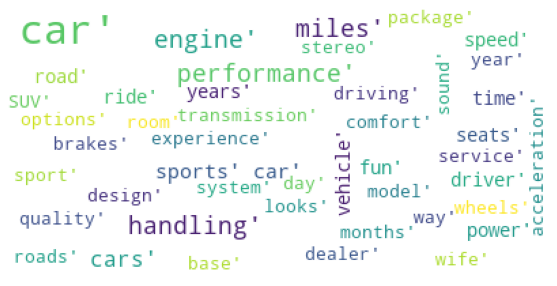

In [58]:
from spacy.lang.en.stop_words import STOP_WORDS
from wordcloud import WordCloud
plt.figure(figsize=(10,5))
wordcloud = WordCloud(background_color="white",
                      stopwords = STOP_WORDS,
                      max_words=45,
                      max_font_size=30,
                      random_state=42
                     ).generate(str(topics))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [45]:
from spacy.matcher import Matcher

matcher = Matcher(nlp.vocab)

# Create a pattern matching two tokens: "Alice" and a Verb
#TEXT is for the exact match and VERB for a verb
pattern = [{"TEXT": "performance"}]

# Add the pattern to the matcher
#the first variable is a unique id for the pattern (alice).
#The second is an optional callback and the third one is our pattern.
matcher.add("performance", [pattern])

matches = matcher(doc)

for match_id, start, end in matches:
    string_id = nlp.vocab.strings[match_id]  # Get string representation
    span = doc[start:end]  # The matched span
    print(match_id, string_id, start, end, span.text)
    
# print("Matches:", [doc[start:end].text for match_id, start, end in matches])

# matched_sents = [] # collect data of matched sentences to be visualized

# def collect_sents(matcher, doc, i, matches, label='MATCH'):
#     """
#     Function to help reformat data for displacy visualization
#     """
#     match_id, start, end = matches[i]
#     span = doc[start : end]  # matched span
#     sent = span.sent  # sentence containing matched span
    
#     # append mock entity for match in displaCy style to matched_sents
    
#     if doc.vocab.strings[match_id] == 'performance':  # don't forget to get string!
#         match_ents = [{'start': span.start_char - sent.start_char,
#                    'end': span.end_char - sent.start_char,
#                    'label': 'DEMOCRATS'}]
#         matched_sents.append({'text': sent.text, 'ents': match_ents })

    
# # declare different patterns
# performance_pattern = [{'POS': 'ADV', 'OP': '*'}, {'POS': 'ADJ'}, {'LOWER': 'performance'}]

# matcher.add('great performance', [performance_pattern])  # add pattern
# matches = matcher(doc)

# spacy.displacy.render(matched_sents, style='ent', manual=True, jupyter=True)


7162342725099726394 performance 130 131 performance


In [59]:
# doc = nlp("The United States of America (USA) are commonly known as the United States (U.S. or US) or America.")

expression = r"[Uu](nited|\.?) ?[Ss](tates|\.?)"
for match in re.finditer(expression, doc.text):
    start, end = match.span()
    span = doc.char_span(start, end)
    # This is a Span object or None if match doesn't map to valid token sequence
    if span is not None:
        print("Found match:", span.text)

Found match: us
Found match: us
Found match: US.


In [ ]:
import re
text